In [23]:
# import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [24]:
# data set path

path = r"/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis"

In [25]:
# import merged data set (from 4.9) 

df_merged = pd.read_pickle(os.path.join(path, '02 data' , 'Prepared Data' , 'orders_products_customers_combined_2.pkl'))

# Task 2. Consideration of possible security implications for the new data. 

In [27]:
# Get an overview of the data set again

df_merged.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,...,median_days_since_order,order_frequency_flag,customer_name,gender,state,age,date_joined,num_dependants,family_status,income
0,0,2539329,1,prior,1,2,8,NaN,196,1,...,20.5,Non-frequent customer,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
1,0,2539329,1,prior,1,2,8,NaN,14084,2,...,20.5,Non-frequent customer,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
2,0,2539329,1,prior,1,2,8,NaN,12427,3,...,20.5,Non-frequent customer,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
3,0,2539329,1,prior,1,2,8,NaN,26088,4,...,20.5,Non-frequent customer,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
4,0,2539329,1,prior,1,2,8,NaN,26405,5,...,20.5,Non-frequent customer,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423


# The sensitive personally identifiable information (PII) in the data set is:

- customer_name → Clearly personal, should be removed or anonymized.
- age, gender, income, family_status, num_dependants → Individual demographic data. This is sensitive, but can be used in aggregated form.

***Next step: Deciding what to do with the PII data***
1. remove: If the data is not required, customer_name, for example, can be completely removed from the data set
2. anonymize: If necessary, age can be converted to age groups or income can be categorized into income classes.
3. use aggregated: You can keep these values for analysis if you can't trace them back to individual people.

***Solution:***
- Remove customer_name as it is directly identifiable.
- divide age into groups (e.g. “18-25”, “26-35” etc.).
- Convert income into income classes (e.g. “low”, “medium”, “high”).
- gender, family_status, num_dependants are retained, but it should be ensured that they cannot be used for direct identification.

### 1. column customer_name is removed from the data record 

In [30]:
# As customer_name enables direct identification, we remove this column:

df_merged = df_merged.drop(columns=['customer_name'])

### 2. Create age groups (age)

In [32]:
# We convert the age into categories so that no individual persons can be identified:

bins = [18, 25, 35, 45, 55, 65, 100]  # age limits
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']

df_merged['age_group'] = pd.cut(df_merged['age'], bins=bins, labels=labels)
df_merged = df_merged.drop(columns=['age'])  # Remove original column

### 3. Create income classes (income)

In [34]:
income_bins = [0, 40000, 70000, 100000, 150000, 300000]  # income limits
income_labels = ['Low', 'Lower-Middle', 'Upper-Middle', 'High', 'Very High']

df_merged['income_group'] = pd.cut(df_merged['income'], bins=income_bins, labels=income_labels)
df_merged = df_merged.drop(columns=['income'])  # Remove original column

### 4. check data

In [36]:
# Check if the process was successful

df_merged.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,...,spending_flag,median_days_since_order,order_frequency_flag,gender,state,date_joined,num_dependants,family_status,age_group,income_group
0,0,2539329,1,prior,1,2,8,NaN,196,1,...,Low spender,20.5,Non-frequent customer,Female,Alabama,2019-02-17,3,married,26-35,Lower-Middle
1,0,2539329,1,prior,1,2,8,NaN,14084,2,...,Low spender,20.5,Non-frequent customer,Female,Alabama,2019-02-17,3,married,26-35,Lower-Middle
2,0,2539329,1,prior,1,2,8,NaN,12427,3,...,Low spender,20.5,Non-frequent customer,Female,Alabama,2019-02-17,3,married,26-35,Lower-Middle
3,0,2539329,1,prior,1,2,8,NaN,26088,4,...,Low spender,20.5,Non-frequent customer,Female,Alabama,2019-02-17,3,married,26-35,Lower-Middle
4,0,2539329,1,prior,1,2,8,NaN,26405,5,...,Low spender,20.5,Non-frequent customer,Female,Alabama,2019-02-17,3,married,26-35,Lower-Middle


## Data security check

***Checked PII data:***
- customer_name removed as it allows direct identification.
- age anonymized by grouping into age categories.
- income anonymized by grouping into income classes.
- gender, family_status, num_dependants retained, as no direct identification is possible and they are relevant for the analysis.

***Reason:***
By aggregating age and income, the analysis option is retained, while at the same time ensuring that no individuals can be identified.

# Task 3. Regional segmentation of the data

### Step 1: Regional allocation

In [40]:
# Dictionary for assigning states to regions
region_map = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

# Function for assigning the region based on the state
def assign_region(state):
    for region, states in region_map.items():
        if state in states:
            return region
    return 'Unknown'  # If a state is missing

# Add new 'Region' column
df_merged['Region'] = df_merged['state'].apply(assign_region)

# Check the allocation
df_merged[['state', 'Region']].head(100)

,state,Region
0,Alabama,South
1,Alabama,South
2,Alabama,South
3,Alabama,South
4,Alabama,South
...,...,...
95,Alaska,West
96,Alaska,West
97,Alaska,West
98,Alaska,West


### 1. calculation of purchasing behavior differences by region

In [42]:
# Group the data by 'Region' and 'spending_flag', then count the occurrences
region_spending_abs = df_merged.groupby('Region')['spending_flag'].value_counts().unstack()

# Display the table to check the distribution before visualization
display(region_spending_abs)

spending_flag,High spender,Low spender
Region,,
Midwest,156129,7447681
Northeast,108343,5620004
South,210182,10591428
West,160807,8139638


### **Overview**
This analysis examines spending behavior across U.S. regions by categorizing customers into **High Spenders** and **Low Spenders**.

### **Findings**
- The **South** has the highest number of **High Spenders**, while the **Northeast** has the lowest.  
- Across all regions, **Low Spenders** dominate.  

### **Next Step**
A stacked bar chart will be used to visualize these differences.

### 2. Spending Behavior by Region (Stacked Bar Chart)

<Figure size 1000x600 with 0 Axes>

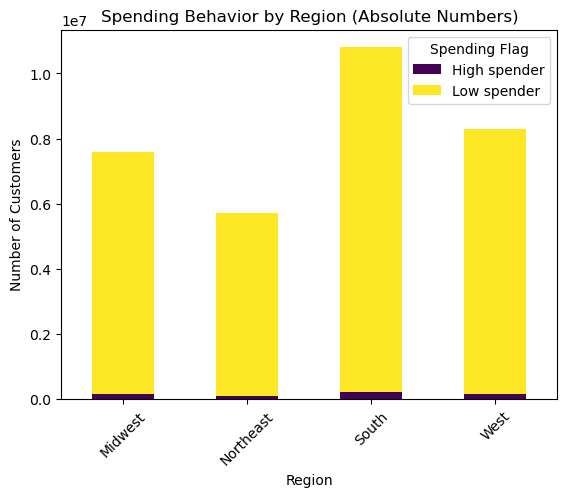

In [49]:
# Set figure size
plt.figure(figsize=(10,6))  

# Create the stacked bar chart
region_spending_abs.plot(kind='bar', stacked=True, colormap='viridis')

# Add title and labels
plt.title("Spending Behavior by Region (Absolute Numbers)")
plt.xlabel("Region")
plt.ylabel("Number of Customers")

# Add a legend
plt.legend(title="Spending Flag")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the figure to the specified path
save_path = "/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis/04 Analysis/Visualizations/spending_behavior_by_region.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)  

# Show the plot
plt.show()

### **Overview**
This stacked bar chart shows the distribution of **High Spenders** and **Low Spenders** across U.S. regions.

### **Insights**
- The **South** has the highest number of customers overall, including the most **High Spenders**.  
- The **Northeast** has the fewest customers and the lowest number of **High Spenders**.  
- Across all regions, **Low Spenders** dominate significantly.  

### **Conclusion**
There is no major regional variation in spending behavior, as Low Spenders make up the vast majority in all regions.

# Task 4. Exclude Low-Activity Customers

### Step 1: Create exclusion flag

In [ ]:
df_merged['exclusion_flag'] = df_merged['order_number'].apply(lambda x: 'Exclude' if x < 5 else 'Keep')

# Checking the distribution
df_merged['exclusion_flag'].value_counts()

### ***What happens here?***

- If order_number < 5, the customer is marked with Exclude.
- Otherwise it remains in the data record with Keep.
- value_counts() shows how many customers are affected.

### Step 2: Filter out low-activity customers

In [ ]:
# Now we filter the data set to keep only customers with at least 5 orders:
df_filtered = df_merged[df_merged['exclusion_flag'] == 'Keep'].copy()

# Check: Number of remaining lines
df_filtered.shape

### Step 3: Export cleansed data set

In [ ]:
# Export data to pkl
df_merged.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'instacart_filtered_data.pkl'))

### **Objective**
To exclude customers with fewer than **5 orders**, as they are not relevant for Instacart's analysis.

### **Process**
- Created an **Exclusion Flag** for low-activity customers.
- Filtered the dataset to keep only customers with **5 or more orders**.
- Exported the cleaned dataset as a **Pickle file (`.pkl`)** for efficient storage and fast access.

### **Results**
- The dataset now includes only **active customers**.
- The cleaned data was saved in:  
   ***02 Data/Prepared Data/instacart_filtered_data.pkl***

 **Next Step:** Customer profiling based on age, income, and purchase behavior.

# ***IMPORTANT INFO***
The remaining tasks for 5. to 8. can be found in the script: **Task 4.10 (Part1B).ipynb**